<h1>House Prices in Germany</h1>

<h2>Table of Contents</h2>

<div>
<ol>
    <li><a href="#Business-case">Business case</a></li>
    <li><a href="#Data-description">Data description</a></li>
    <li><a href="#Visualize-Data-per-Map">Visualize Data per Map</a></li>
    <li><a href="#Prepare-Data">Prepare Data</a>
    <ol>
        <li><a href="#Replace-NaN">Replace NaN</a></li>
        <li><a href="#Transform-Data">Transform Data</a></li>
        <li><a href="#Filter-Data">Filter Data</a></li>
    </ol>   
    <li><a href="#Explorative-Analysis">Explorative Analysis</a>
    <ol>
        <li><a href="#Bivariate-Analysis">Bivariate Analysis</a></li>
        <li><a href="#Univariate-Analysis">Univariate Analysis</a></li>
        <li><a href="#Dummy-Variables">Dummy Variables</a></li>
    </ol>
    <li><a href="#Feature-Scaling">Feature Scaling</a>
    <ol>
        <li><a href="#Standardization">Standardization</a></li>
        <li><a href="#Normalization">Normalization</a></li>
    </ol>
    <li><a href="#Regression-Analysis">Regression Analysis</a>
    <ol>
        <li><a href="#Split-Data">Split Data</a></li>
        <li><a href="#Linear-Regression">Linear Regression</a></li>
        <li><a href="#Polynominal-Regression">Polynominal Regression</a></li>
        <li><a href="#Decision-Trees">Decision Trees</a></li>
        <li><a href="#Random-Forest-Regression">Random Forest Regression</a></li>
        <li><a href="#SVM">SVM</a></li>
        <li><a href="#Comparison">Comparison</a></li>
    </ol>
</ol>
</div>

<h2>Business case</h2>

The goal of our analysis is to predict houseprices in Germany. We will focus on freestanding single homes.<br>


<h2>Data description</h2>

The data is scraped from a leading online platform for real estate in Germany. The file only contains houses which were listed on Sunday, December 9, 2018.<br>
The whole file has a size of about 25 MB. Some entries are still in German. These will be translated in a later version.


In [1]:
# Imports
import folium
import warnings
import geopandas as gpd
import branca.colormap as cm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import ensemble
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('house_prices_germany_20181209_english.csv')

In [3]:
# Translate columns from English to German
df = df.rename(columns={
    'anzahl_fotos': 'number_photos', 'ausstattung': 'furnishing', 'ausstattung_level': 'furnishing_level', 'ausstattung_text': 'furnishing_text',
    'badezimmer': 'bathrooms', 'baujahr': 'build_year', 'beschreibung': 'description', 'bezugsfrei': 'move_in', 'effizienzklasse': 'efficiency_class',
    'endenergiebedarf': 'final_energy_demand', 'energieausweis': 'energy_pass', 'energieausweistyp': 'energy_pass_type',
    'energietraeger': 'energy_carrier', 'energieverbauchskennwert': 'energy_consumption_value', 'etagenanzahl': 'floors',
    'garage_stellplatz': 'garage', 'grundstueck': 'lot', 'heizungsart': 'heating_type', 'kaufpreis': 'price', 'lage_text': 'location_text',
    'modernisierung': 'modernization', 'nutzflaeche': 'available_surface', 'objektzustand': 'condition',
    'plz': 'zip', 'schlafzimmer': 'bedrooms', 'sonstiges_text': 'other_text', 'stadt': 'city', 'strasse': 'street', 'typ': 'type', 'wohnflaeche': 'area', 'zimmer': 'rooms'
})

# Drop columns which are not necessary
df = df.drop(columns=['anbieter', 'anbieter_stadt', 'anbieter_strasse', 'url', 'mieteinnahmen', 'scraper_start', 'datum', 'ueberschrift', 'id', 'nebenkosten', 'heizkosten', 'kaution'])

In [4]:
df.columns

Index(['number_photos', 'furnishing', 'furnishing_level', 'furnishing_text',
       'bathrooms', 'build_year', 'description', 'move_in', 'efficiency_class',
       'final_energy_demand', 'energy_pass', 'energy_pass_type',
       'energy_carrier', 'energy_consumption_value', 'floors', 'garage', 'lot',
       'heating_type', 'price', 'location_text', 'modernization',
       'available_surface', 'condition', 'zip', 'bedrooms', 'other_text',
       'city', 'street', 'type', 'area', 'rooms'],
      dtype='object')

In [5]:
df.shape

(55622, 31)

In [6]:
df.head()

,number_photos,furnishing,furnishing_level,furnishing_text,bathrooms,build_year,description,move_in,efficiency_class,final_energy_demand,...,available_surface,condition,zip,bedrooms,other_text,city,street,type,area,rooms
0,5.0,basement; rented,NaN,NaN,8.0,1900,667.0,NaN,D,NaN,...,NaN,Gepflegt,6712,16.0,1109.0,Zeitz,NaN,Mehrfamilienhaus,502.0,24
1,6.0,basement; rented,NaN,NaN,7.0,1900,919.0,NaN,D,NaN,...,NaN,Gepflegt,6712,9.0,1105.0,Zeitz,NaN,Mehrfamilienhaus,420.0,17
2,15.0,comissionfree,NaN,NaN,NaN,1900,1278.0,NaN,NaN,NaN,...,NaN,NaN,6618,NaN,937.0,Molauer Land,NaN,Wohnimmobilie (sonstige),430.0,15
3,35.0,basement,basic,NaN,NaN,1925,775.0,NaN,NaN,NaN,...,NaN,NaN,6712,NaN,1489.0,Zeitz,NaN,Doppelhaushälfte,120.0,6
4,30.0,NaN,ordinary,NaN,NaN,1900,985.0,NaN,NaN,NaN,...,NaN,Vollständig renoviert,6712,NaN,1489.0,Zeitz,NaN,Mehrfamilienhaus,590.0,31


<h2>Visualize Data per Map</h2>

In [7]:
df['zip'] = df['zip'].astype(str)
df['zip'] = df['zip'].str.zfill(5)

house_prices_geo = df[['price', 'zip']].groupby(by=["zip"]).agg("mean").reset_index(drop=False).rename(columns={'zip': 'postcode'})

# Colormap
colormap = cm.LinearColormap(colors=['green','red'], vmin=house_prices_geo['price'].min(), vmax=house_prices_geo['price'].sort_values()[:6300].max()) 

# Join with geographical data
germany_zips = gpd.read_file("postleitzahlen.geojson")
house_map = germany_zips.merge(house_prices_geo, on="postcode")

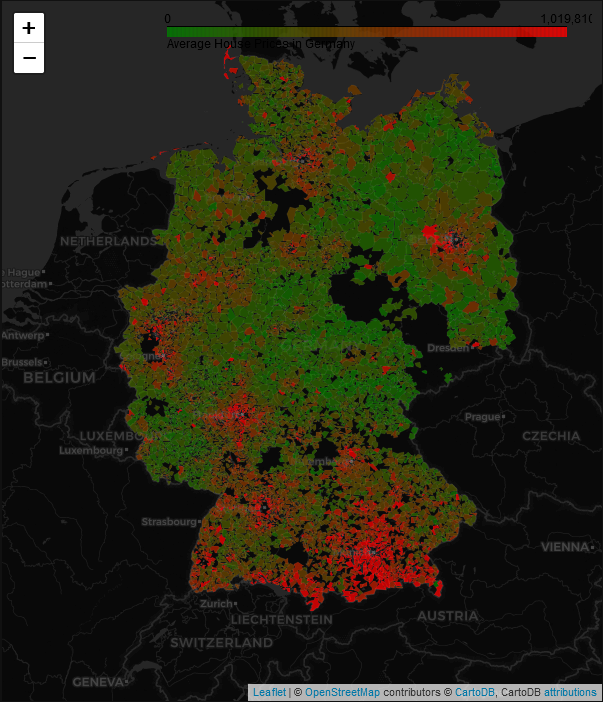

In [8]:
f = folium.Figure(width=600, height=700)
colormap.caption = 'Average House Prices in Germany'
germany_map = folium.Map(location=[51, 10], zoom_start=6.3, tiles=None).add_to(f)
folium.TileLayer('cartodbdark_matter', name='Dark Map', control=False).add_to(germany_map)
style_function = lambda x: {'weight': 0.05, 'color': 'white', 'fillColor': colormap(x['properties']['price']), 'fillOpacity': 0.75}
highlight_function = lambda x: {'fillColor': '#000000', 'color': '#000000', 'fillOpacity': 0.50, 'weight': 0.1}
info=folium.features.GeoJson(
    house_map, 
    style_function=style_function, 
    control=False, 
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['postcode', 'price'], 
        aliases=['ZIP Code: ', 'Average House Price'],
        sticky=True
        )
    )
colormap.add_to(germany_map)
germany_map.add_child(info)
germany_map

<h2>Prepare Data</h2>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55622 entries, 0 to 55621
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number_photos             55416 non-null  float64
 1   furnishing                43175 non-null  object 
 2   furnishing_level          26430 non-null  object 
 3   furnishing_text           38748 non-null  float64
 4   bathrooms                 38992 non-null  float64
 5   build_year                51534 non-null  object 
 6   description               55480 non-null  float64
 7   move_in                   30460 non-null  object 
 8   efficiency_class          22839 non-null  object 
 9   final_energy_demand       19477 non-null  object 
 10  energy_pass               40089 non-null  object 
 11  energy_pass_type          33201 non-null  object 
 12  energy_carrier            42583 non-null  object 
 13  energy_consumption_value  3100 non-null   object 
 14  floors

<h3>Replace NaN</h3>

In [10]:
# Drop not relevant columns
df = df.drop(['final_energy_demand', 'energy_pass', 'energy_pass_type', 'energy_consumption_value', 'street'], axis=1)

# Drop NaN for specific columns
df = df.dropna(subset=['number_photos', 'furnishing_level', 'condition', 'build_year'])

# Replace NaN with 0 for specific columns
df['furnishing_text'].fillna(0, inplace=True)
df['description'].fillna(0, inplace=True)
df['available_surface'].fillna(0, inplace=True)
df['garage'].fillna(0, inplace=True)
df['other_text'].fillna(0, inplace=True)

# Replace NaN with 1 for specific columns
df['bathrooms'].fillna(1, inplace=True)
df['bedrooms'].fillna(1, inplace=True)

In [11]:
df.columns

Index(['number_photos', 'furnishing', 'furnishing_level', 'furnishing_text',
       'bathrooms', 'build_year', 'description', 'move_in', 'efficiency_class',
       'energy_carrier', 'floors', 'garage', 'lot', 'heating_type', 'price',
       'location_text', 'modernization', 'available_surface', 'condition',
       'zip', 'bedrooms', 'other_text', 'city', 'type', 'area', 'rooms'],
      dtype='object')

In [12]:
# Get an overview of NaN
df.isnull().sum()

number_photos            0
furnishing            1703
furnishing_level         0
furnishing_text          0
bathrooms                0
build_year               0
description              0
move_in               6518
efficiency_class     11952
energy_carrier        2877
floors                4842
garage                   0
lot                      0
heating_type          1473
price                    0
location_text         1624
modernization        11307
available_surface        0
condition                0
zip                      0
bedrooms                 0
other_text               0
city                     0
type                   861
area                     0
rooms                    0
dtype: int64

<h3>Transform Data</h3>

In [13]:
# Furnishing details
furnishing_list = [element for furnishing in df.furnishing.dropna().unique() for element in furnishing.split('; ')]
furnishing_list_unique = list(dict.fromkeys(furnishing_list))

# Add new columns and fill them with 0 or 1
for i in furnishing_list_unique:
    df[i] = 0

for i in furnishing_list_unique:
    df.loc[[df[df['furnishing'].str.contains(i) == True].index][0], [i]] = 1
    
del df['furnishing']

# Assign values for furnishing level
df['numerical_furnishing_level'] = 0
df.loc[[df['furnishing_level'][df['furnishing_level'] == 'basic'].index][0], ['numerical_furnishing_level']] = 1
df.loc[[df['furnishing_level'][df['furnishing_level'] == 'ordinary'].index][0], ['numerical_furnishing_level']] = 2
df.loc[[df['furnishing_level'][df['furnishing_level'] == 'upper'].index][0], ['numerical_furnishing_level']] = 3
df.loc[[df['furnishing_level'][df['furnishing_level'] == 'luxury'].index][0], ['numerical_furnishing_level']] = 4

# Transform decimal point
df.lot = df.lot.str.replace('.', '')
df.lot = df.lot.str.replace(',', '.')
df.lot = df.lot.astype(float)

df.rooms = df.rooms.str.replace(',', '.')
df.rooms = df.rooms.astype(float)

# Replace unknown
df = df[df['build_year'] != 'unbekannt']
df.build_year = df.build_year.astype(int)

# Transform garage types
df['outdoor_parking_space'] = 0
df['underground_parking_space'] = 0
df['garages'] = 0
df['duplex_parking_space'] = 0
df['carports'] = 0
df['parking_space'] = 0

df['number_outdoor_parking_space'] = 0
df['number_underground_parking_space'] = 0
df['number_garage'] = 0
df['number_duplex_parking_space'] = 0
df['number_carports'] = 0
df['number_parking_space'] = 0

df.loc[[df[df['garage'].str.contains(' Außenstellplatz') == True].index][0], ['outdoor_parking_space']] = 1
df.loc[[df[df['garage'].str.contains(' Tiefgaragen') == True].index][0], ['underground_parking_space']] = 1
df.loc[[df[df['garage'].str.contains(' Garagen') == True].index][0], ['garage']] = 1
df.loc[[df[df['garage'].str.contains(' Duplex-Stellplätze') == True].index][0], ['duplex_parking_space']] = 1
df.loc[[df[df['garage'].str.contains(' Carport') == True].index][0], ['carports']] = 1
df.loc[[df[df['garage'].str.contains(' Stellplätze') == True].index][0], ['parking_space']] = 1

df['number_outdoor_parking_space'] = df[df['garage'].str.contains(' Außenstellplatz') == True]['garage'].str.replace(' Außenstellplatz', '').str.replace(' Außenstellplätze', '').str.strip().replace('', '1').fillna(0).astype(int).fillna(0)
df['number_underground_parking_space'] = df[df['garage'].str.contains(' Tiefgaragen') == True]['garage'].str.replace(' Tiefgaragen-Stellplatz', '').str.replace('Tiefgaragen-Stellplätze', '').str.strip().replace('', '1').fillna(0).astype(int).fillna(0)
df['number_garage'] = df[df['garage'].str.contains(' Garage') == True]['garage'].str.replace(' Garage', '').str.replace(' Garagen', '').str.strip().replace('', '1').fillna(0).astype(int).fillna(0)
df['number_duplex_parking_space'] = df[df['garage'].str.contains(' Duplex') == True]['garage'].str.replace(' Duplex-Stellplätze', '').str.replace(' Duplex-Stellplatz', '').str.strip().replace('', '1').fillna(0).astype(int).fillna(0)
df['number_carports'] = df[df['garage'].str.contains(' Carport') == True]['garage'].str.replace(' Carports', '').str.replace(' Carport', '').str.strip().replace('', '1').fillna(0).astype(int).fillna(0)
df['number_parking_space'] = df[df['garage'].str.contains(' Stellpl') == True]['garage'].str.replace(' Stellplätze', '').str.replace(' Stellplatz', '').str.strip().replace('', '1').fillna(0).astype(int).fillna(0)

df['number_outdoor_parking_space'] = df['number_outdoor_parking_space'].fillna(0)
df['number_underground_parking_space'] = df['number_underground_parking_space'].fillna(0)
df['number_garage'] = df['number_garage'].fillna(0)
df['number_duplex_parking_space'] = df['number_duplex_parking_space'].fillna(0)
df['number_carports'] = df['number_carports'].fillna(0)
df['number_parking_space'] = df['number_parking_space'].fillna(0)

# Transform modernization
df = df.dropna(subset=['modernization'])
df.modernization = df.modernization.str.replace(' zuletzt ', '').astype(int)

df = df.reset_index(drop=True)

<h3>Filter Data</h3>

In [14]:
# Filter values
df = df[df['bathrooms'] < 15]
df = df[df['rooms'] < 20]
df = df[df['bedrooms'] < 9]
df = df[df['lot'] < 1500]
df = df[df['type'].isin([' Einfamilienhaus (freistehend) '])]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2978 entries, 4 to 8900
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   number_photos                     2978 non-null   float64
 1   furnishing_level                  2978 non-null   object 
 2   furnishing_text                   2978 non-null   float64
 3   bathrooms                         2978 non-null   float64
 4   build_year                        2978 non-null   int32  
 5   description                       2978 non-null   float64
 6   move_in                           2254 non-null   object 
 7   efficiency_class                  1450 non-null   object 
 8   energy_carrier                    2669 non-null   object 
 9   floors                            2438 non-null   float64
 10  garage                            2978 non-null   object 
 11  lot                               2978 non-null   float64
 12  heatin

<h2>Explorative Analysis</h2>

In [16]:
df.describe()

,number_photos,furnishing_text,bathrooms,build_year,description,floors,lot,price,location_text,modernization,...,garages,duplex_parking_space,carports,parking_space,number_outdoor_parking_space,number_underground_parking_space,number_garage,number_duplex_parking_space,number_carports,number_parking_space
count,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2438.000000,2978.000000,2.978000e+03,2725.000000,2978.000000,...,2978.0,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000
mean,18.613499,522.572868,1.880792,1960.064137,1144.052720,2.132075,707.794627,4.272789e+05,671.730275,2009.546676,...,0.0,0.001679,0.080255,0.106783,0.047683,0.008731,0.245467,0.005373,0.143721,0.375084
std,11.116148,595.747059,0.840821,44.394205,731.133365,0.812669,314.669092,3.890422e+05,520.269738,9.783549,...,0.0,0.040948,0.271734,0.308889,0.213130,0.146362,0.430436,0.100242,0.553636,1.194550
min,1.000000,0.000000,0.000000,1466.000000,0.000000,0.000000,0.000000,0.000000e+00,8.000000,1917.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,108.000000,1.000000,1939.000000,587.000000,2.000000,490.000000,2.150000e+05,281.000000,2006.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.000000,329.500000,2.000000,1969.000000,1005.000000,2.000000,690.000000,3.450000e+05,558.000000,2013.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24.000000,699.750000,2.000000,1988.000000,1588.750000,3.000000,903.000000,5.200000e+05,927.000000,2016.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,98.000000,3928.000000,8.000000,2019.000000,3924.000000,25.000000,1498.000000,5.000000e+06,3761.000000,2020.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,3.000000,8.000000,24.000000


In [17]:
# Get correlations and sort for absolute values
corr = df.corr()
corr.price.abs().sort_values(ascending=False)

price                               1.000000
area                                0.470893
numerical_furnishing_level          0.447200
bathrooms                           0.294910
guest_toilet                        0.242662
rooms                               0.229442
build_year                          0.193687
lot                                 0.176402
modernization                       0.149139
furnishing_text                     0.144796
description                         0.128658
granny_flat                         0.118848
floors                              0.095402
bedrooms                            0.084640
basement                            0.083377
cottage_able                        0.073003
entrance_no_steps                   0.072458
outdoor_parking_space               0.067706
number_outdoor_parking_space        0.067706
location_text                       0.042664
number_garage                       0.040172
rented                              0.035404
comissionf

#### Important variables will be:
* price
* area
* numerical_furnishing_level
* bathrooms
* guest_toilet
* rooms
* build_year
* lot
* modernization
* furnishing_text
* description
* granny_flat
* floors
* bedrooms
* basement
* condition
* furnishing_level
* efficiency_class
* energy_carrier
* heating_type
* comissionfree
* rented

In [18]:
cols_to_analyze = [
    'price', 'area', 'numerical_furnishing_level', 'bathrooms', 'guest_toilet', 'rooms',
    'build_year', 'lot', 'modernization', 'furnishing_text', 'description', 'granny_flat',
    'floors', 'bedrooms', 'basement', 'condition', 'furnishing_level', 'efficiency_class',
    'energy_carrier', 'heating_type', 'comissionfree', 'rented'
]

In [19]:
df_filtered = df[cols_to_analyze]

In [20]:
df_filtered.describe()

,price,area,numerical_furnishing_level,bathrooms,guest_toilet,rooms,build_year,lot,modernization,furnishing_text,description,granny_flat,floors,bedrooms,basement,comissionfree,rented
count,2.978000e+03,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2438.000000,2978.000000,2978.000000,2978.000000,2978.000000
mean,4.272789e+05,177.702270,2.394560,1.880792,0.668570,6.120047,1960.064137,707.794627,2009.546676,522.572868,1144.052720,0.195433,2.132075,3.046676,0.720282,0.191404,0.050034
std,3.890422e+05,66.479765,0.720959,0.840821,0.470806,1.954756,44.394205,314.669092,9.783549,595.747059,731.133365,0.396600,0.812669,1.667983,0.448936,0.393472,0.218051
min,0.000000e+00,40.000000,1.000000,0.000000,0.000000,2.000000,1466.000000,0.000000,1917.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.150000e+05,130.000000,2.000000,1.000000,0.000000,5.000000,1939.000000,490.000000,2006.000000,108.000000,587.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,3.450000e+05,165.000000,2.000000,2.000000,1.000000,6.000000,1969.000000,690.000000,2013.000000,329.500000,1005.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000
75%,5.200000e+05,211.000000,3.000000,2.000000,1.000000,7.000000,1988.000000,903.000000,2016.000000,699.750000,1588.750000,0.000000,3.000000,4.000000,1.000000,0.000000,0.000000
max,5.000000e+06,615.000000,4.000000,8.000000,1.000000,19.000000,2019.000000,1498.000000,2020.000000,3928.000000,3924.000000,1.000000,25.000000,8.000000,1.000000,1.000000,1.000000


In [21]:
df_filtered.shape

(2978, 22)

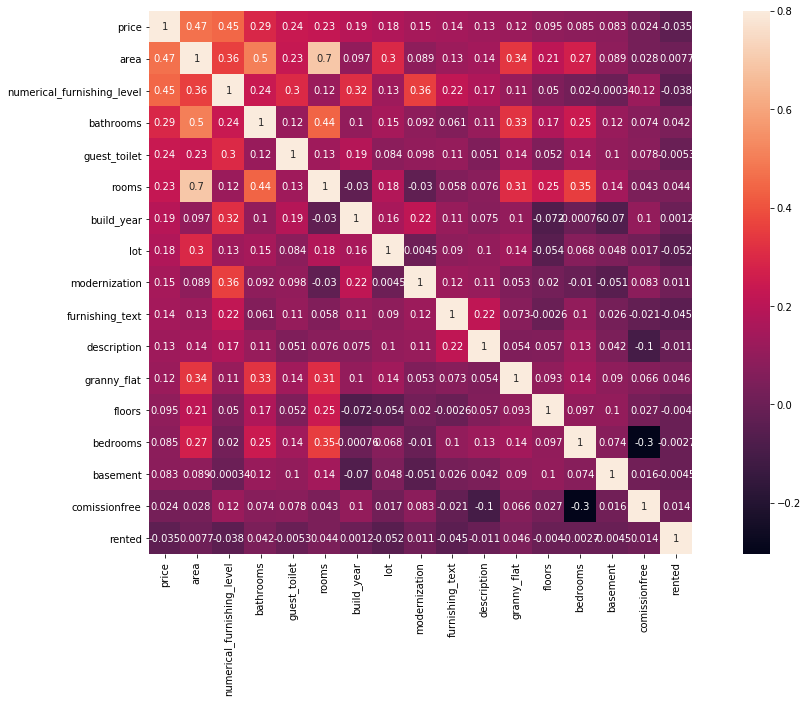

In [22]:
# Show the correlation in a graphical way
figure, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(df_filtered.corr(), vmax=.8, square=True, annot=True);

<h3>Bivariate Analysis</h3>

(0, 5255436.772706973)

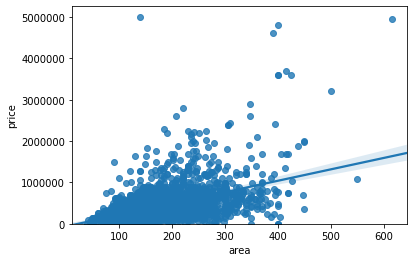

In [24]:
sns.regplot(x='area', y='price', data=df_filtered)
plt.ylim(0,)

(0, 5283986.115860985)

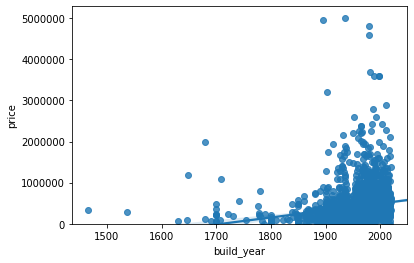

In [25]:
sns.regplot(x='build_year', y='price', data=df_filtered)
plt.ylim(0,)

(0, 5250713.310449371)

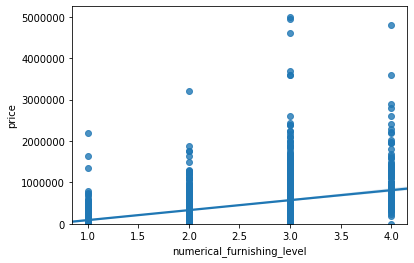

In [26]:
sns.regplot(x='numerical_furnishing_level', y='price', data=df_filtered)
plt.ylim(0,)

(0, 5250713.310449371)

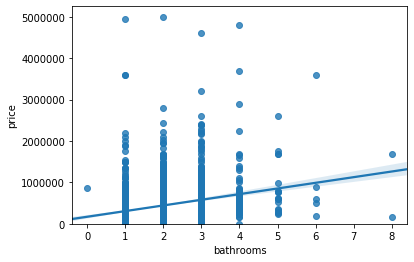

In [27]:
sns.regplot(x='bathrooms', y='price', data=df_filtered)
plt.ylim(0,)

(0, 5250713.310449371)

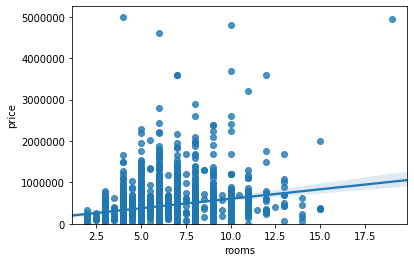

In [28]:
sns.regplot(x='rooms', y='price', data=df_filtered)
plt.ylim(0,)

(0, 5250711.825410213)

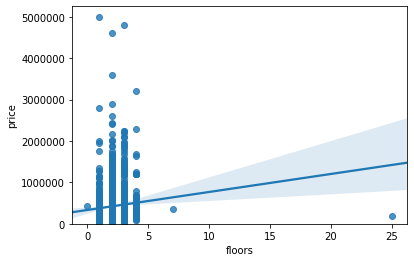

In [29]:
sns.regplot(x='floors', y='price', data=df_filtered)
plt.ylim(0,)

(0, 5250713.310449371)

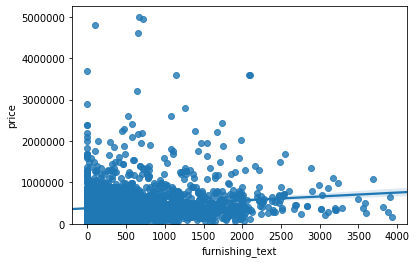

In [30]:
sns.regplot(x='furnishing_text', y='price', data=df_filtered)
plt.ylim(0,)

(0, 5250713.310449371)

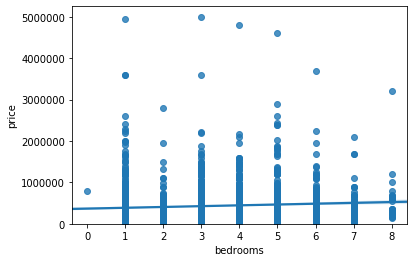

In [31]:
sns.regplot(x='bedrooms', y='price', data=df_filtered)
plt.ylim(0,)

(0, 5250713.310449371)

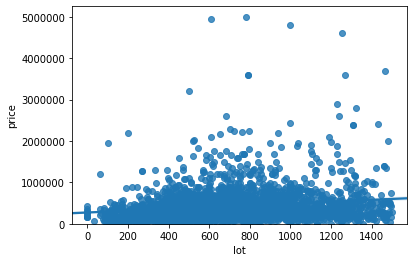

In [32]:
sns.regplot(x='lot', y='price', data=df_filtered)
plt.ylim(0,)

(0, 5265226.3585123615)

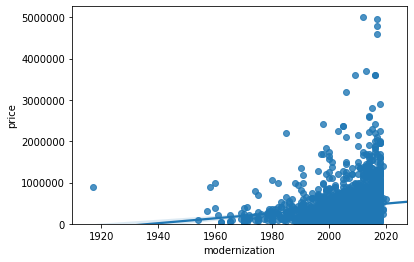

In [33]:
sns.regplot(x='modernization', y='price', data=df_filtered)
plt.ylim(0,)

<h3>Univariate Analysis</h3>

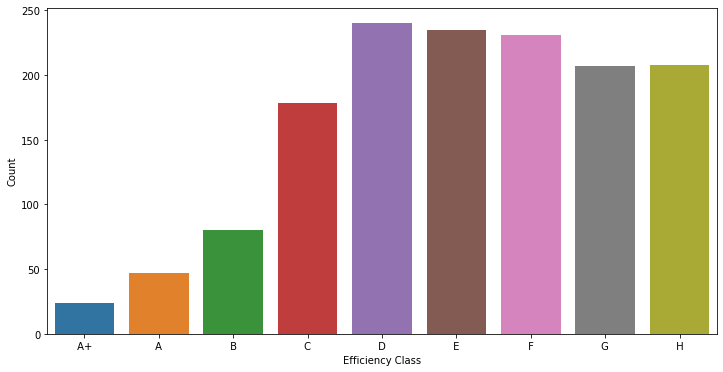

In [34]:
plt.figure(figsize=(12, 6))
sns.countplot(x='efficiency_class', data=df_filtered, order=[' A+ ', ' A ', ' B ', ' C ', ' D ', ' E ', ' F ', ' G ', ' H '])
plt.ylabel('Count')
plt.xlabel('Efficiency Class')
plt.show()

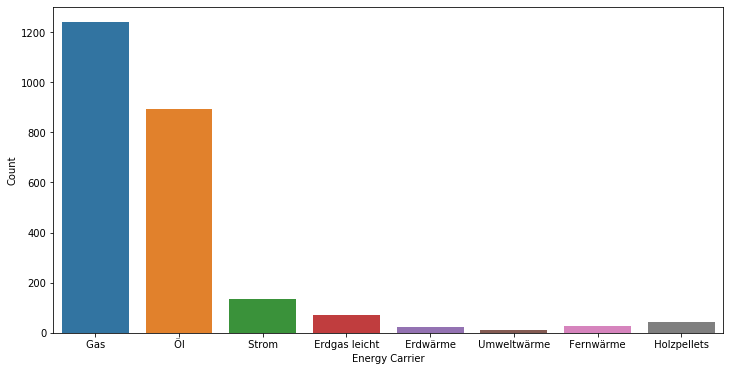

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(x='energy_carrier', data=df_filtered, order=[' Gas ', ' Öl ', ' Strom ', ' Erdgas leicht ', ' Erdwärme ', ' Umweltwärme ', ' Fernwärme ', ' Holzpellets '])
plt.ylabel('Count')
plt.xlabel('Energy Carrier')
plt.show()

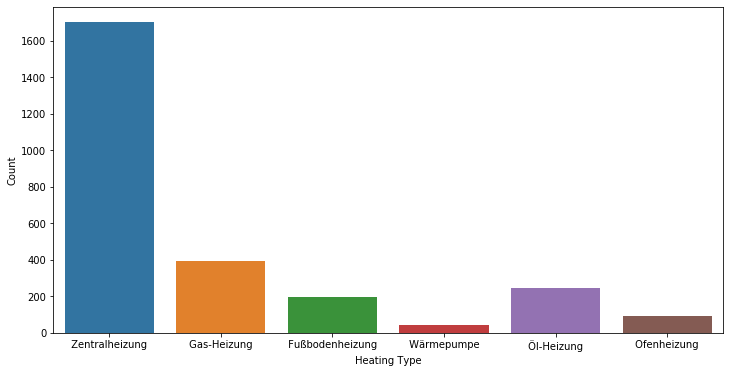

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(x='heating_type', data=df, order=[' Zentralheizung ', ' Gas-Heizung ', ' Fußbodenheizung ', ' Wärmepumpe ', ' Öl-Heizung ', ' Ofenheizung '])
plt.ylabel('Count')
plt.xlabel('Heating Type')
plt.show()

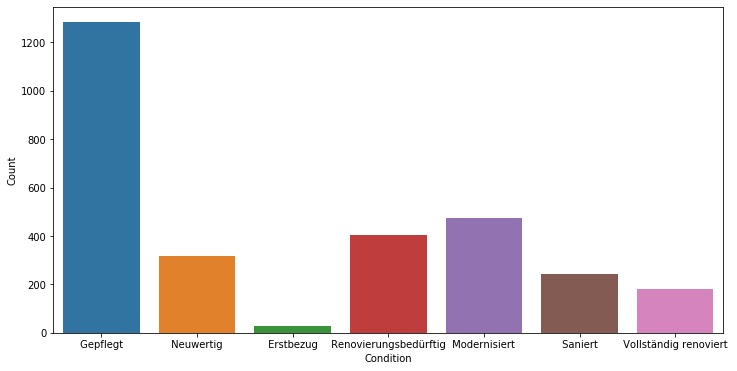

In [37]:
plt.figure(figsize=(12, 6))
sns.countplot(x='condition', data=df_filtered, order=[' Gepflegt ', ' Neuwertig ', ' Erstbezug ', ' Renovierungsbedürftig ', ' Modernisiert ', ' Saniert ', ' Vollständig renoviert '])
plt.ylabel('Count')
plt.xlabel('Condition')
plt.show()

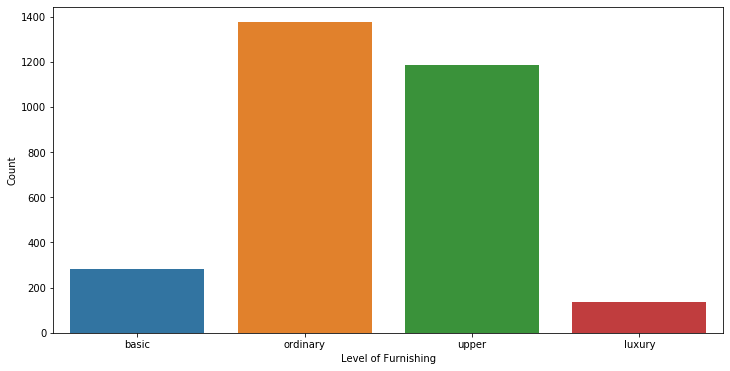

In [38]:
plt.figure(figsize=(12, 6))
sns.countplot(x='furnishing_level', data=df_filtered, order=['basic', 'ordinary', 'upper', 'luxury'])
plt.ylabel('Count')
plt.xlabel('Level of Furnishing')
plt.show()

<h3>Dummy Variables</h3>

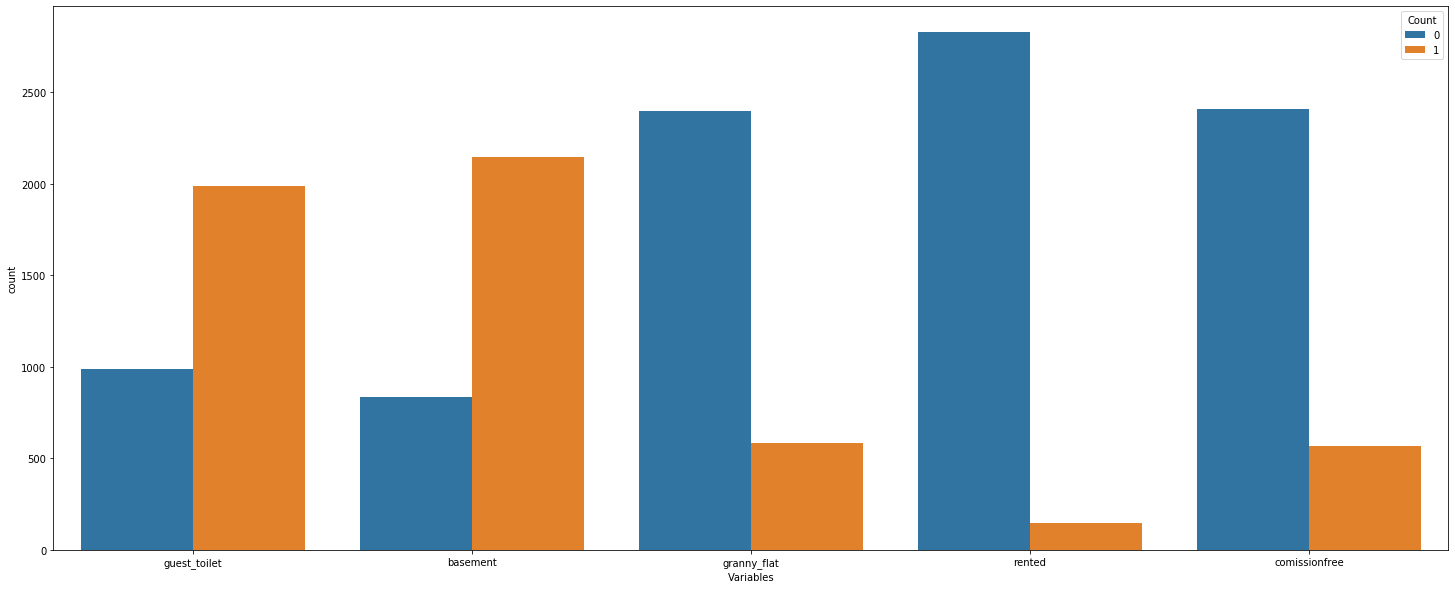

In [39]:
figure, ax = plt.subplots(figsize=(25, 10))
p = sns.countplot(data=pd.melt(df_filtered[['guest_toilet', 'basement', 'granny_flat', 'rented', 'comissionfree', 'price']], id_vars=['price'], var_name='Variables', value_name='Count'), x='Variables', hue='Count')

In [40]:
df_filtered = pd.get_dummies(df_filtered, columns=['condition'], drop_first=True)

<h2>Feature Scaling</h2>

<h3>Standardization</h3>

Standardization means that we rescale the data to have a mean of 0 and a standard deviation of 1.

In [41]:
df_filtered.corr()['price'].sort_values(ascending=False)

price                                   1.000000
area                                    0.470893
numerical_furnishing_level              0.447200
bathrooms                               0.294910
guest_toilet                            0.242662
rooms                                   0.229442
condition_ Neuwertig                    0.221513
build_year                              0.193687
lot                                     0.176402
modernization                           0.149139
furnishing_text                         0.144796
description                             0.128658
granny_flat                             0.118848
floors                                  0.095402
bedrooms                                0.084640
basement                                0.083377
condition_ Erstbezug                    0.058769
condition_ Vollständig renoviert        0.042054
condition_ Saniert                      0.027225
comissionfree                           0.024020
condition_ Modernisi

In [42]:
df_final = df_filtered[['price', 'area', 'numerical_furnishing_level', 'bathrooms', 'guest_toilet', 'rooms', 'condition_ Neuwertig ', 'build_year', 'lot', 'modernization', 'floors', 'condition_ Renovierungsbedürftig ', 'furnishing_text']]
df_final = df_final.dropna().reset_index(drop=True)

In [43]:
df_final

,price,area,numerical_furnishing_level,bathrooms,guest_toilet,rooms,condition_ Neuwertig,build_year,lot,modernization,floors,condition_ Renovierungsbedürftig,furnishing_text
0,340000.0,230.00,3,2.0,1,6.0,0,1993,676.0,2010,2.0,0,264.0
1,77766.0,123.23,2,1.0,1,5.0,0,2005,769.0,2005,3.0,1,88.0
2,250000.0,138.00,2,2.0,1,4.0,0,1961,723.0,2008,2.0,0,231.0
3,170000.0,147.00,2,2.0,1,5.0,0,1985,908.0,2018,2.0,0,202.0
4,548500.0,295.00,3,2.0,1,8.0,0,1983,1073.0,2005,3.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433,1199000.0,238.00,3,3.0,1,7.0,0,1955,602.0,2008,4.0,0,551.0
2434,789900.0,245.00,2,3.0,0,9.0,0,1890,371.0,2007,3.0,0,270.0
2435,450000.0,218.00,2,2.0,1,8.0,0,1979,764.0,2011,2.0,0,1226.0
2436,373000.0,120.00,2,2.0,0,5.0,0,1928,1302.0,2013,2.0,0,61.0


In [44]:
scaler = preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(df_final.values)
df_scaled = pd.DataFrame(scaled_features, index=df_final.index, columns=df_final.columns)

<h3>Normalization</h3>

<p>Normalization means the scaling of a variable so the variable values range from 0 to 1.
</p>

In [45]:
normalized_values = preprocessing.normalize(df_scaled.values)
df_normalized = pd.DataFrame(normalized_values, index=df_scaled.index, columns=df_scaled.columns)

<h2>Regression analysis</h2>

<h3>Split data</h3>

In [46]:
X = df_normalized.drop(columns=["price"])
y = df_normalized["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [47]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1950, 12)
Training Labels Shape: (488, 12)
Testing Features Shape: (1950,)
Testing Labels Shape: (488,)


<h3>Linear Regression</h3>

In [48]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
lin_reg_score = lin_reg.score(X_test, y_test)
lin_reg_mse = mean_squared_error(y_test, lin_reg.predict(X_test))

print('Linear regression R2: ' + str(lin_reg_score))
print('Linear regression MSE: ' + str(lin_reg_mse))
print('Linear regression Coefs: \n', lin_reg.coef_)

Linear regression R2: 0.3296623836156001
Linear regression MSE: 0.03958253298672279
Linear regression Coefs: 
 [ 0.25263886  0.21541355  0.06363368  0.07174887 -0.09547445  0.05743285
  0.05412463  0.01254836 -0.01122575  0.02862409  0.03109322  0.04387499]


<h3>Polynominal Regression</h3>

In [50]:
poly_feat = PolynomialFeatures(degree = 2)
poly_X_train = poly_feat.fit_transform(X_train)
poly_X_test = poly_feat.fit_transform(X_test)
poly_reg = LinearRegression()
poly_reg.fit(poly_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
poly_reg_score = poly_reg.score(poly_X_test, y_test)
poly_reg_mse = mean_squared_error(y_test, poly_reg.predict(poly_X_test))

print('Polynominal regression R2: ' + str(poly_reg_score))
print('Polynominal regression MSE: ' + str(poly_reg_mse))
print('Polynominal regression Coefs: \n', poly_reg.coef_)

Polynominal regression R2: 0.6532782852872119
Polynominal regression MSE: 0.02047345005619083
Polynominal regression Coefs: 
 [-1.41891985e-17  1.52535837e-01  1.82756004e-01  6.67099846e-02
  2.31470985e-02 -4.12584787e-02  9.20088746e-02  6.98594163e-02
  1.61920082e-02  1.02294779e-02  2.85472462e-02  1.60714946e-01
  2.31860173e-02 -1.26071671e+00 -3.37740100e-02 -9.54649463e-02
  6.68629615e-02 -7.31521532e-02  1.43761087e-02  1.87331510e-02
  7.29110169e-02  6.07949195e-02  2.79085569e-02 -1.47937185e-01
  2.29759428e-02 -1.19415296e+00 -2.56562734e-02  3.80253554e-03
 -4.99396466e-02 -3.08084573e-03 -4.72888414e-02 -2.70524222e-02
  6.22681733e-03 -7.86609923e-03  3.18809798e-04  6.66012422e-02
 -1.19243747e+00 -5.88807697e-02  4.33577356e-02  1.06319910e-01
  1.41766941e-02 -4.49582148e-02 -8.31712638e-02  1.26907148e-02
 -6.17633068e-02  5.95052204e-02 -1.50154966e+00 -3.15532679e-02
  2.00396554e-02 -3.88935538e-02 -1.51181654e-02  1.13836183e-02
 -3.51104488e-02  1.14790360e

<h3>Decision Tree</h3>

In [52]:
dt = DecisionTreeRegressor(random_state=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [53]:
dt_score = dt.score(X_test, y_test)
dt_mse = mean_squared_error(y_test, dt.predict(X_test))

print('Decision Tree R2: ' + str(dt_score))
print('Decision Tree MSE: ' + str(dt_mse))
print('Decision Tree Feature Importance: \n', dt.feature_importances_)

Decision Tree R2: -0.05356186287475939
Decision Tree MSE: 0.0622114083582611
Decision Tree Feature Importance: 
 [0.13640697 0.25215881 0.05750084 0.05233419 0.07867892 0.03109036
 0.08988234 0.08759544 0.04344812 0.05146907 0.05801833 0.06141661]


<h3>Random Forest Regression</h3>

In [54]:
rf = ensemble.RandomForestRegressor(n_estimators=1000, random_state=1)
rf.fit(X_train, y_train);

In [55]:
rf_score = rf.score(X_test, y_test)
rf_mse = mean_squared_error(y_test, rf.predict(X_test))

print('Random Forest R2: ' + str(rf_score))
print('Random Forest MSE: ' + str(rf_mse))
print('Random Forest Feature Importance: \n', rf.feature_importances_)

Random Forest R2: 0.46597202108032676
Random Forest MSE: 0.03153363256777066
Random Forest Feature Importance: 
 [0.13461568 0.25923406 0.06498956 0.05129532 0.07738018 0.03524897
 0.07893069 0.06352857 0.05779445 0.04513429 0.06687443 0.06497381]


<h3>SVM</h3>

In [56]:
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
svm_score = svm_reg.score(X_test, y_test)
svm_mse = mean_squared_error(y_test, svm_reg.predict(X_test))

print('SVM R2: ' + str(svm_score))
print('SVM MSE: ' + str(svm_mse))

SVM R2: 0.30280565172717466
SVM MSE: 0.04116838681605581


<h3>Comparison</h3>

In [58]:
lin_reg_list = [lin_reg_score, lin_reg_mse]
poly_reg_list = [poly_reg_score, poly_reg_mse]
dt_list = [dt_score, dt_mse]
rf_list = [rf_score, rf_mse]
svm_list = [svm_score, svm_mse]
index = ['R2', 'MSE']
df_comparison_data = {'Linear Regression': lin_reg_list, 'Polynominal Regression': poly_reg_list, 'Decision Tree': dt_list, 'Random Forest': rf_list, 'SVM': svm_list, 'index': index}
df_comparison = pd.DataFrame.from_dict(df_comparison_data).set_index('index')

In [59]:
df_comparison

,Linear Regression,Polynominal Regression,Decision Tree,Random Forest,SVM
index,,,,,
R2,0.329662,0.653278,-0.053562,0.465972,0.302806
MSE,0.039583,0.020473,0.062211,0.031534,0.041168
